In [1]:
#user-defined
import ipynb.fs.full.helper as hp

#dataframes
import pandas as pd
import h5py

#speedup
import multiprocessing as mp

#suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.TimeSeries = pd.Series 

#math
import numpy as np
import math as m
from scipy.spatial.distance import cdist
import statsmodels.api as sm
import statsmodels.formula.api as smf

#plots
import pylab as plt
import matplotlib.pyplot as plt
import matplotlib as mat
from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar
import seaborn as sns
sns.set()

#misc
import time
np.set_printoptions(suppress=True)


In [2]:
#load data
set_number = 5
dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Total/'
# dir = '~/Documents/Myfiles/DataAnalysis/data/Sprints/Run03/Set0'+str(set_number)+'/'
dir_save = '../../../Research/Images/Images/'

wind_load = 'Run03X.hdf'


# wind_load= 'wind0'+str(set_number)+'Run03_InterpolatedX.hdf'
# wind_load_small = 'wind0'+str(set_number)+'Run03_InterpolatedXs.hdf'
 

windn = pd.read_hdf(dir+wind_load)
# windsm = pd.read_hdf(dir+wind_load_small)

In [3]:
df = pd.DataFrame()
df = windn
dt= df.master_time[1]-df.master_time[0]
sync_time = df.master_time-df.master_time[0]
df.insert(1,'time',sync_time)
# plt.figure(figsize=(15,5))
# plt.plot(df.time,df.odor)
# plt.xlabel('Time')
# plt.ylabel('Odor Concentration')

Text(0, 0.5, 'odor concentration')

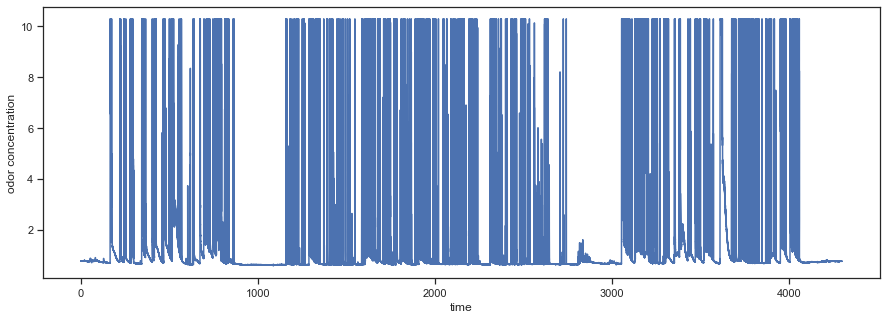

In [31]:
fig, ax = plt.subplots(figsize=(15,5))
# sns.scatterplot(data=df, x ='time', y ='odor', hue='odor', legend=False)
# sns.lineplot(data=df,x='time',y='odor')
plt.plot(df.time,df.odor)
plt.xlabel('time')
plt.ylabel('odor concentration')

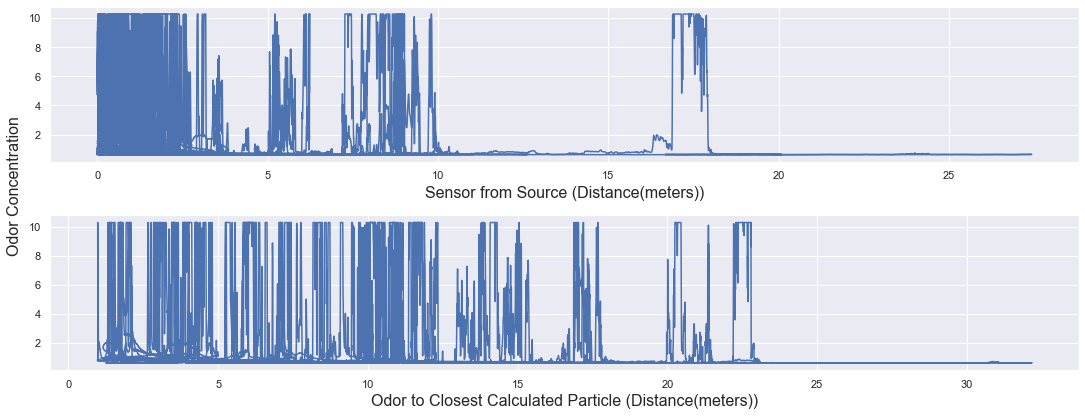

In [140]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(15,6) , gridspec_kw={'height_ratios': [4,4]})
# f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
ax1.plot(df.odor_from_source, df.odor )
ax1.set_xlabel('Sensor from Source (Distance(meters))', fontsize = 16)
ax2.plot(df.odor_from_wind, df.odor)
ax2.set_xlabel('Odor to Closest Calculated Particle (Distance(meters))', fontsize = 16)
f.text(0.001, 0.55, 'Odor Concentration', ha='center', va='center', rotation='vertical', fontsize = 16)
f.tight_layout()

In [5]:
odor_position = np.array([[df.xsrc[i],df.ysrc[i]] for i in range (len(df))]) 
source = np.array([[0,0]])
distance_from_source = np.array([cdist(odor_position,source)]).flatten()

In [6]:
## getting the indexes for odor over a threshold to determine each encounter
def get_index(df):
    idx = []
    for i in range(len(df.odor)):
        if (df.odor[i]>1.5):
            idx.append(df.index[i])

    from itertools import groupby
    from operator import itemgetter
    index = [ ]
    for k, g in groupby(enumerate(idx),lambda ix : ix[0] - ix[1]):
        index.append((list((map(itemgetter(1), g)))))
    return index

In [7]:
fdf=pd.DataFrame()
index = get_index(df)
i = 0

#to compare with R^2 analysis
avg_dist_fromsource = []
while i<len(index):
    avg_dist_fromsource.append(np.mean(distance_from_source[index[i]]))
    i+=1
fdf['avg_dist_fromsource']=avg_dist_fromsource

In [8]:
# mean odor concentration
i = 0
concentration = []
while i<len(index):
    concentration.append(np.mean(df.odor[index[i]]))
    i+=1
fdf['odor'] = concentration

# time of the encounters
i = 0
intermittency = []
dt = df.time[1]-df.time[0]   ## dt is constant, dt * length gives length of time
while i < len(index):
    intermittency.append(dt*(len(index[i])))
    i+=1
fdf['length_of_encounter'] = intermittency

#time between the encounters
i = 0
time_between_encounters = []
while i < len(index):
    if i < 90:
        time_between_encounters.append((index[i+1][0] - index[i][-1])*dt)
        i+=1
    else:
        time_between_encounters.append(0)
        i+=1
fdf['odor_intermittency'] = time_between_encounters

## Odor Standard Deviation
i = 0
st_dev = []
while i<len(index):
    st_dev.append(np.std(df.odor[index[i]]))
    i+=1
fdf['odor_stdev'] = st_dev

## Trisonica Mean Pressure
i = 0
pressure = []
while i<len(index):
    pressure.append(np.mean(df.trisonica_pressure[index[i]]))
    i+=1
fdf['tri_pressure'] = pressure

## Trisonica Mean Temperature
i = 0
temperature = []
while i<len(index):
    temperature.append(np.mean(df.trisonica_temperature[index[i]]))
    i+=1
fdf['tri_temperature'] = temperature

## Trisonica Mean Linear acceleration
i = 0
linear_acc_x = []
while i<len(index):
    linear_acc_x.append(np.mean(df.imu_linear_acc_x[index[i]]))
    i+=1
fdf['linear_acc_x'] = linear_acc_x

i = 0
linear_acc_y = []
while i<len(index):
    linear_acc_y.append(np.mean(df.imu_linear_acc_y[index[i]]))
    i+=1
fdf['linear_acc_y'] = linear_acc_y

i = 0
linear_acc_z = []
while i<len(index):
    linear_acc_z.append(np.mean(df.imu_linear_acc_z[index[i]]))
    i+=1
fdf['linear_acc_z'] = linear_acc_z

## Trisonica Mean Angular vel
i = 0
angular_vel_x = []
while i<len(index):
    angular_vel_x.append(np.mean(df.imu_angular_x[index[i]]))
    i+=1
fdf['imu_angular_x'] = angular_vel_x

i = 0
angular_vel_y = []
while i<len(index):
    angular_vel_y.append(np.mean(df.imu_angular_y[index[i]]))
    i+=1
fdf['imu_angular_y'] = angular_vel_y

i = 0
angular_vel_z = []
while i<len(index):
    angular_vel_z.append(np.mean(df.imu_angular_z[index[i]]))
    i+=1
fdf['imu_angular_z'] = angular_vel_z



##TODO: more features

In [9]:
#finding sensor motion relative to wind direction from stationery

sensor_direction = np.array(np.arctan2(df.gps_linear_y,df.gps_linear_x)* 180 / np.pi)

for i in range(len(sensor_direction)):
    if (sensor_direction[i] <0.0): 
        sensor_direction[i]+=360.0
    else:
        sensor_direction[i]=sensor_direction[i]

fdf['relative_motion']=sensor_direction - df.D

In [10]:
fdf.keys()

Index(['avg_dist_fromsource', 'odor', 'length_of_encounter',
       'odor_intermittency', 'odor_stdev', 'tri_pressure', 'tri_temperature',
       'linear_acc_x', 'linear_acc_y', 'linear_acc_z', 'imu_angular_x',
       'imu_angular_y', 'imu_angular_z', 'relative_motion'],
      dtype='object')

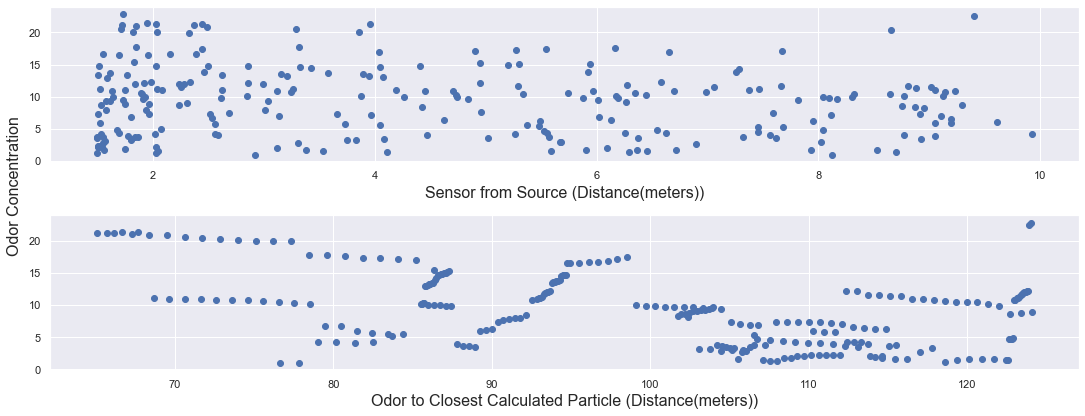

In [101]:
f, (ax1,ax2) = plt.subplots(2,1, figsize =(15,6) , gridspec_kw={'height_ratios': [4,4]})
# f.suptitle('Odor Positions from Wind Particle', fontsize = 16)
ax1.scatter(fdf.odor, fdf.avg_dist_fromsource )
ax1.set_xlabel('Sensor from Source (Distance(meters))', fontsize = 16)
ax2.scatter(fdf.relative_motion, fdf.avg_dist_fromsource)
ax2.set_xlabel('Odor to Closest Calculated Particle (Distance(meters))', fontsize = 16)
f.text(0.001, 0.55, 'Odor Concentration', ha='center', va='center', rotation='vertical', fontsize = 16)
f.tight_layout()

<AxesSubplot:xlabel='avg_dist_fromsource', ylabel='length_of_encounter'>

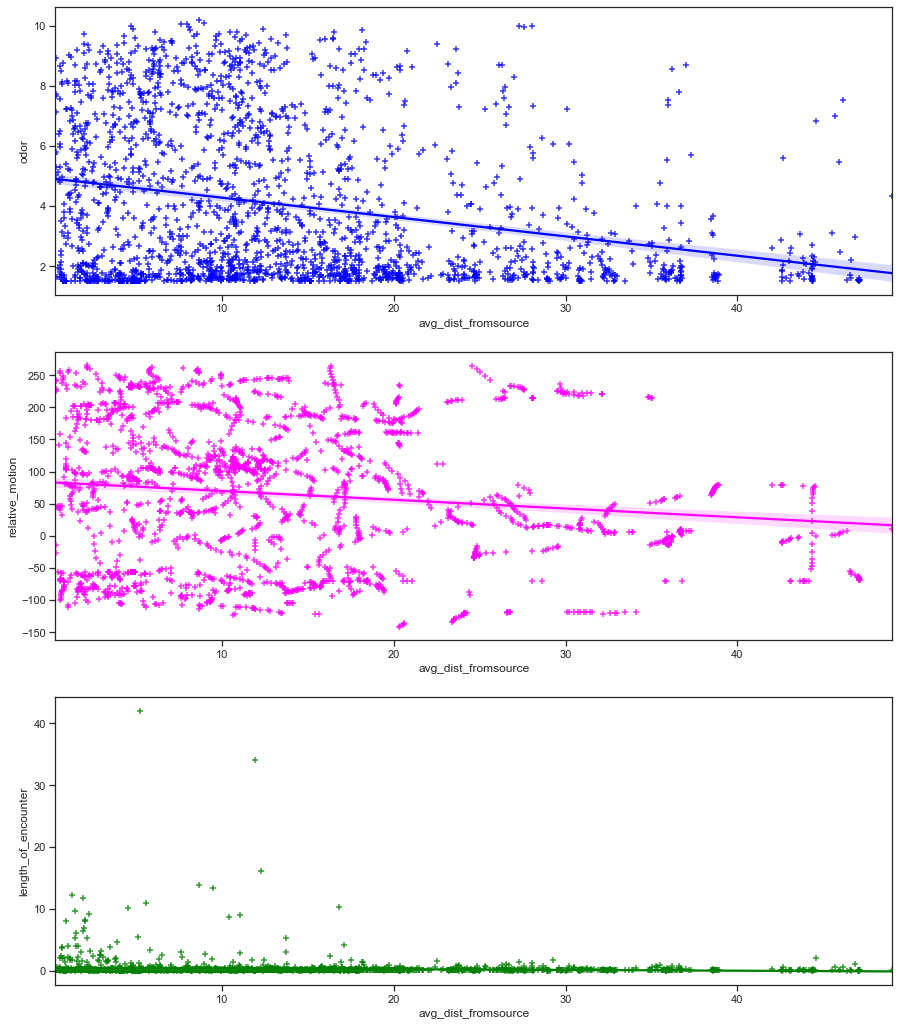

In [28]:
sns.set_style('ticks')
fig, (ax1,ax2,ax3) = plt.subplots(3,1)
fig.set_size_inches(15,18)
sns.regplot(y=fdf.odor, x=fdf.avg_dist_fromsource, color='blue', marker='+', ax=ax1)
sns.regplot(y=fdf.relative_motion, x=fdf.avg_dist_fromsource, color='magenta', marker='+', ax=ax2)
sns.regplot(y=fdf.length_of_encounter, x=fdf.avg_dist_fromsource, color='green', marker='+', ax=ax3)

In [26]:
# odor_distance_model = smf.ols(formula='avg_dist_fromsource ~ odor + odor_intermittency + length_of_encounter + odor_stdev + tri_pressure + tri_temperature + linear_acc_x + linear_acc_y + linear_acc_z + imu_angular_x + imu_angular_y + imu_angular_z', data=fdf).fit()
encounters=smf.ols(formula='avg_dist_fromsource~ odor+length_of_encounter+odor_intermittency+relative_motion+ odor_stdev + tri_pressure + tri_temperature', data=fdf).fit()
print(encounters.summary())

                             OLS Regression Results                            
Dep. Variable:     avg_dist_fromsource   R-squared:                       0.188
Model:                             OLS   Adj. R-squared:                  0.185
Method:                  Least Squares   F-statistic:                     69.04
Date:                 Fri, 23 Apr 2021   Prob (F-statistic):           6.20e-90
Time:                         16:44:20   Log-Likelihood:                -7736.3
No. Observations:                 2101   AIC:                         1.549e+04
Df Residuals:                     2093   BIC:                         1.553e+04
Df Model:                            7                                         
Covariance Type:             nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            539

In [15]:
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

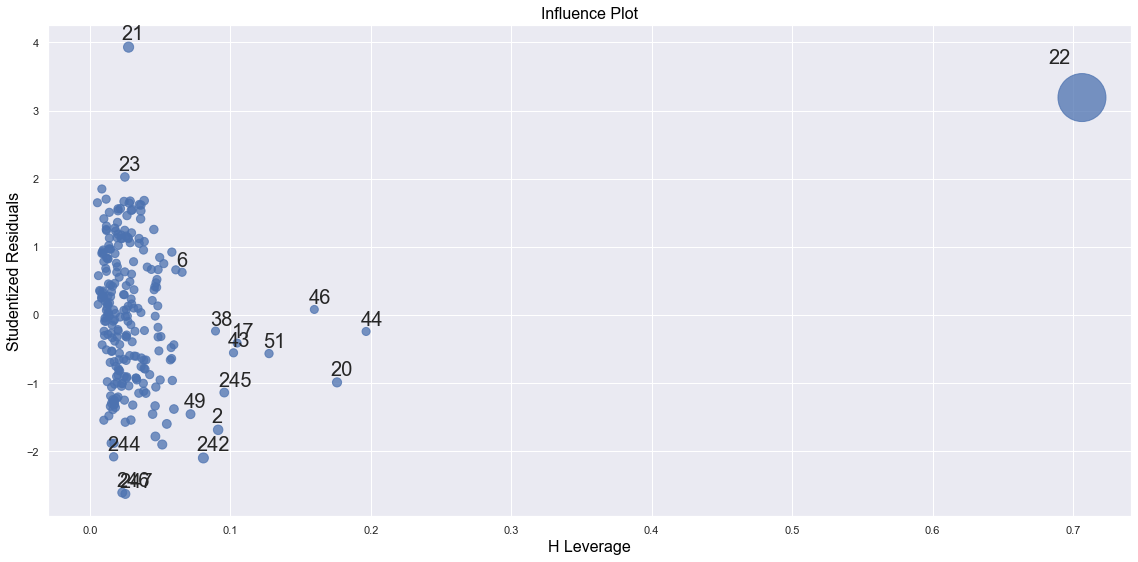

In [16]:
fig = sm.graphics.influence_plot(odor_distance_model, criterion="cooks")
fig.tight_layout(pad=1.0)
# fig.savefig('influenceplot.jpeg')

In [17]:
plt.rc("figure", figsize=(15,30))
plt.rc("font")

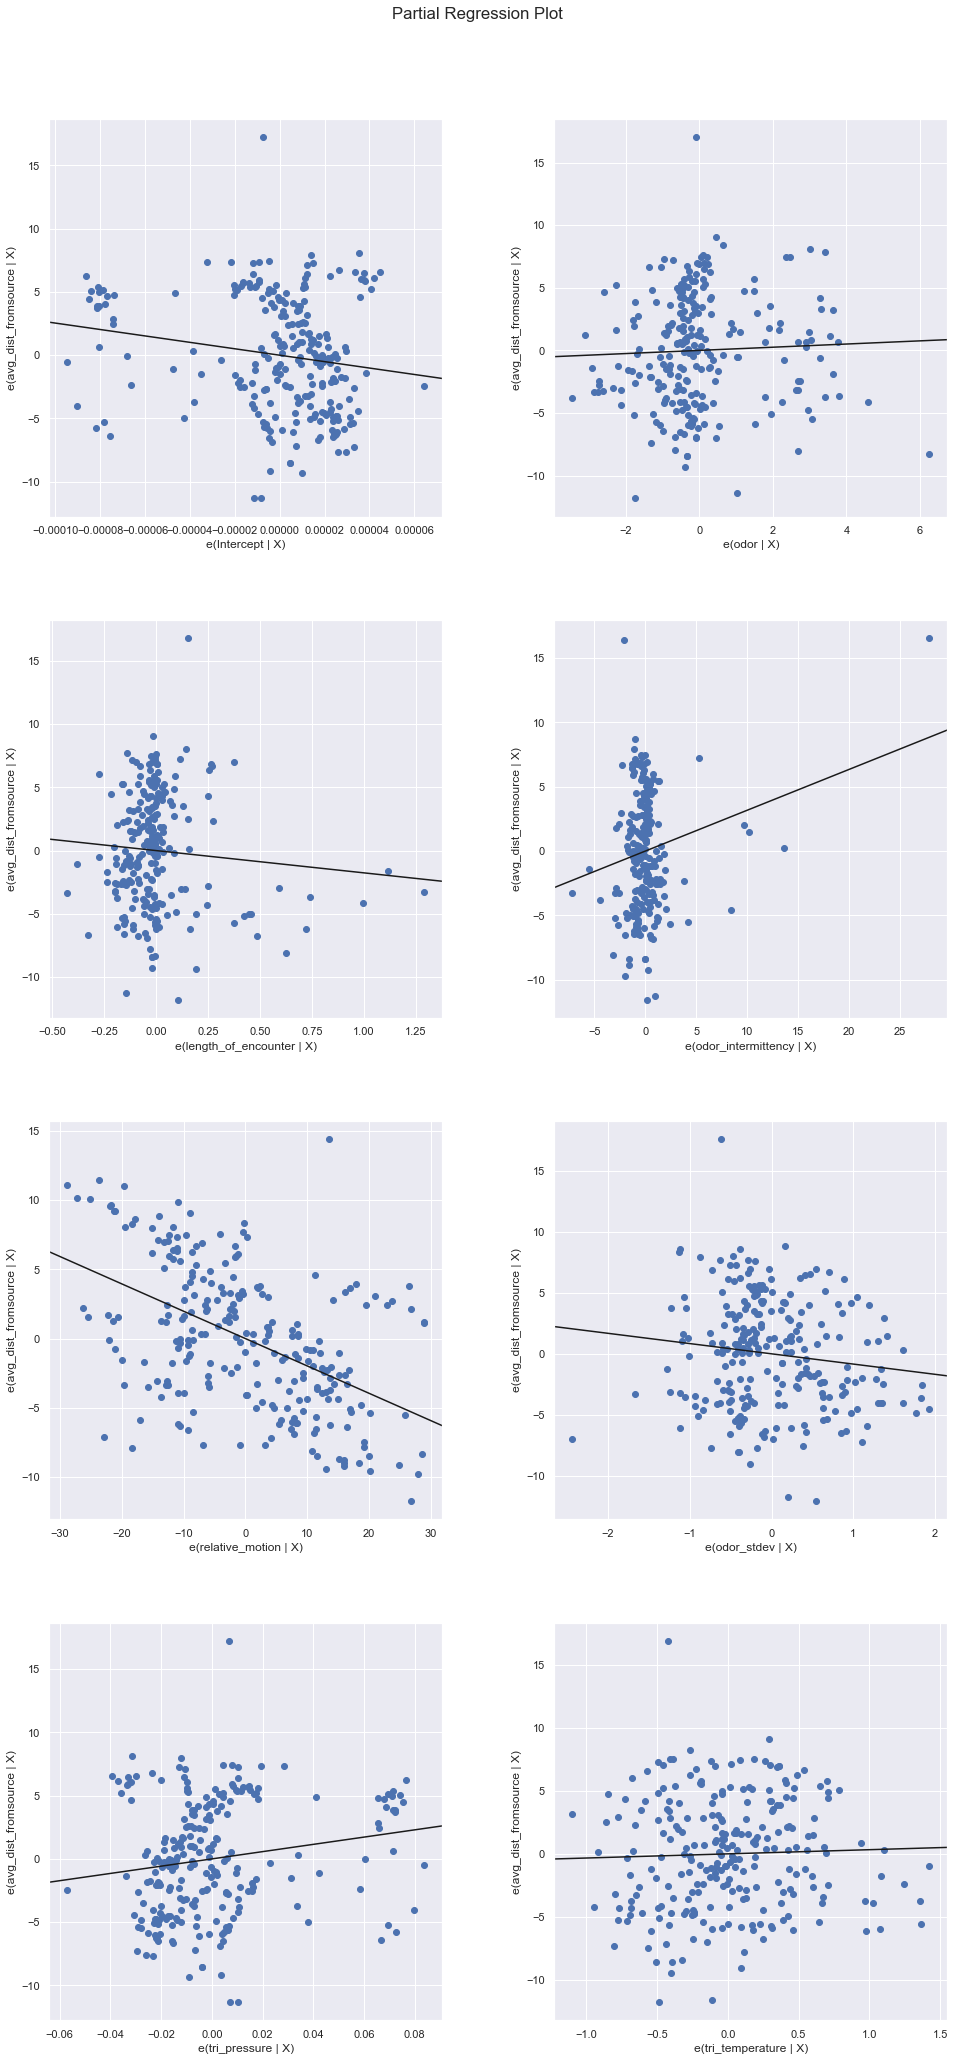

In [20]:
fig = sm.graphics.plot_partregress_grid(odor_distance_model)
fig.tight_layout(pad=5.0)
# fig.savefig('regressplot.jpeg')

### Finding odor encounter distance from source

In [ ]:
# df_pos['time'] = df_tmp['time']
# df_pos['distance']=hp.haversine_distance(df_tmp._ublox_gps_fix_latitude.astype(float),df_tmp._ublox_gps_fix_longitude.astype(float), 39.67650835454546,-119.82060767454543)
# df_pos['odor_concentration'] = df_tmp['_analog_output_data']